# Прогнозирование временных рядов

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline

In [5]:
df = pd.read_csv('wine_Austral.dat', sep='\t')
df.head()

,fort,dry,sweet,red,rose,spark,total,year_,month_,date_
0,2585,1954,85,464,112,1686,15136,1980,1,JAN 1980
1,3368,2302,89,675,118,1591,16733,1980,2,FEB 1980
2,3210,3054,109,703,129,2304,20016,1980,3,MAR 1980
3,3111,2414,95,887,99,1712,17708,1980,4,APR 1980
4,3756,2226,91,1139,116,1471,18019,1980,5,MAY 1980


Данные: продажа вин в Австралии с января 1980 по июнь 1994 в тысячах литров

In [6]:
df.tail(15)

,fort,dry,sweet,red,rose,spark,total,year_,month_,date_
160,2329,3136,185,2255,41,1831,25236,1993,5,MAY 1993
161,2660,2824,175,2255,55,1515,24735,1993,6,JUN 1993
162,2923,3644,252,3057,57,2048,29356,1993,7,JUL 1993
163,2626,4694,319,3330,54,2795,31234,1993,8,AUG 1993
164,2132,2914,202,1896,46,1749,22724,1993,9,SEP 1993
165,1772,3686,254,2096,52,3339,28496,1993,10,OCT 1993
166,2526,4358,336,2374,48,4227,32857,1993,11,NOV 1993
167,2755,5587,431,2535,77,6410,37198,1993,12,DEC 1993
168,1154,2265,150,1041,30,1197,13652,1994,1,JAN 1994
169,1568,3685,280,1728,35,1968,22784,1994,2,FEB 1994


In [7]:
df.drop(labels = [174],axis = 0, inplace = True)

In [8]:
df.dtypes

fort      object
dry       object
sweet     object
red       object
rose      object
spark     object
total     object
year_      int64
month_     int64
date_     object
dtype: object

In [9]:
df['red'] = df['red'].astype(float)
y = df['red']

Сделаем прогноз на 8 месяцев вперёд для красного вина.

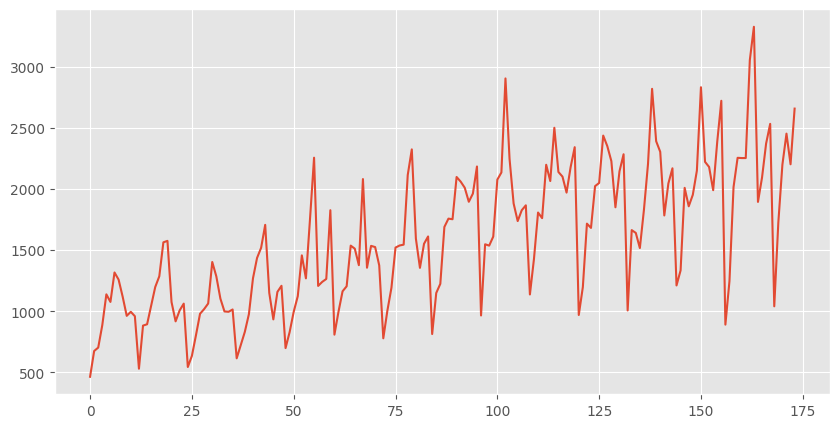

In [10]:
plt.figure(figsize=(10,5))
y.plot();

## Экспоненциальное сглаживание

In [11]:
from statsmodels.tsa.api import ExponentialSmoothing

In [12]:
fit = ExponentialSmoothing(np.asarray(y) ,seasonal_periods=12 ,trend='additive', seasonal='multiplicative', damped_trend = True).fit()

In [13]:
len(y)

174

In [14]:
fitted = fit.predict(0, 181)

In [15]:
fitted[-8:]

array([3175.31246651, 3003.25010739, 2410.21106276, 2234.6227673 ,
       2512.46896012, 2692.68830859, 1186.72345877, 1676.12602072])

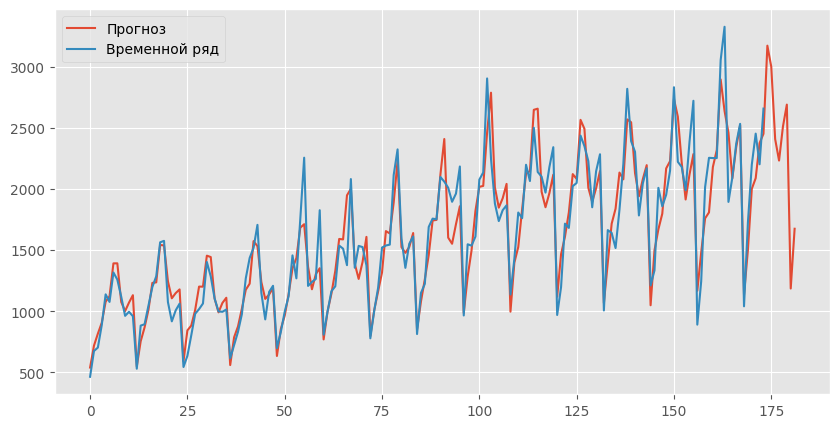

In [19]:
plt.figure(figsize=(10,5))
plt.plot(fitted, label='Прогноз')
plt.plot(np.asarray(y), label='Временной ряд')
plt.legend(loc='best')
plt.show()

## Сезонная декомпозиция

In [17]:
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression

In [21]:
red = df[df.columns[3]]

In [22]:
result = seasonal_decompose(y, model='multiplicative', period=12)

<Figure size 1800x800 with 0 Axes>

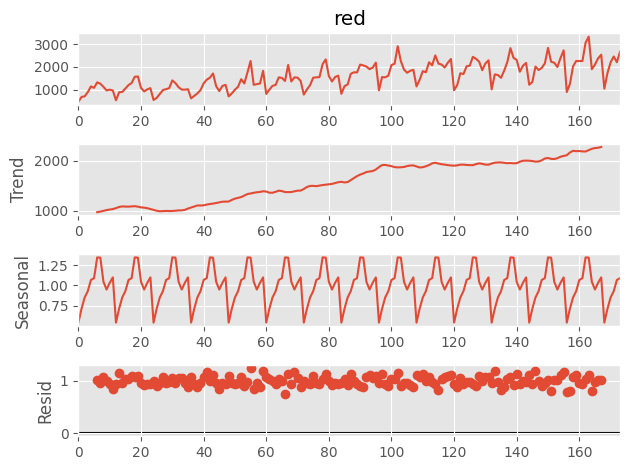

In [23]:
plt.figure(figsize=(18,8))
result.plot();

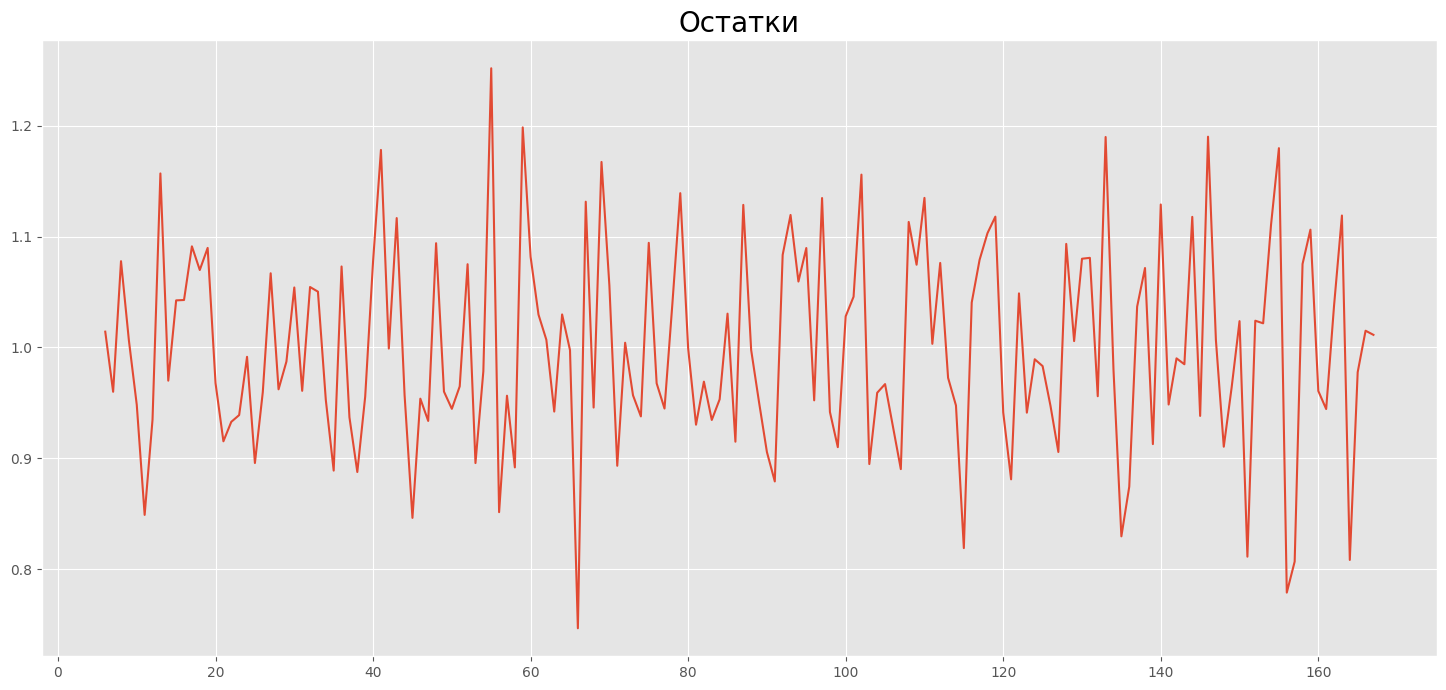

In [24]:
plt.figure(figsize=(18,8))
result.resid.plot()
plt.title("Остатки", fontsize=20)
plt.show()

In [27]:
trend_2 = result.trend.dropna()
trend_2

6       966.250000
7       977.666667
8       994.291667
9      1008.833333
10     1017.916667
          ...     
163    2216.708333
164    2244.416667
165    2260.333333
166    2266.458333
167    2281.208333
Name: trend, Length: 162, dtype: float64

Спрогнозируем тренд, используя полиномиальную регрессию

In [28]:
trend_3 = pd.DataFrame({"trend": trend_2, 'month_num': range(13, 175)})
trend_3['num^2'] = trend_3['month_num']**2

trend_3

,trend,month_num,num^2
6,966.250000,13,169
7,977.666667,14,196
8,994.291667,15,225
9,1008.833333,16,256
10,1017.916667,17,289
...,...,...,...
163,2216.708333,170,28900
164,2244.416667,171,29241
165,2260.333333,172,29584
166,2266.458333,173,29929


In [29]:
y = trend_3['trend']

X1 = trend_3.drop(columns=['trend', 'num^2'])
X2 = trend_3.drop(columns=['trend'])

In [30]:
model1 = LinearRegression()
model1.fit(X1, y)

coef = pd.DataFrame(list(zip(['intercept'] + X1.columns.tolist(), [model1.intercept_] + model1.coef_.tolist())), columns=['predictor', 'coef'])
coef

,predictor,coef
0,intercept,802.892498
1,month_num,8.470486


In [31]:
model2 = LinearRegression()
model2.fit(X2, y)

coef = pd.DataFrame(list(zip(['intercept'] + X2.columns.tolist(), [model2.intercept_] + model2.coef_.tolist())),
                    columns=['predictor', 'coef'])
coef

,predictor,coef
0,intercept,724.860282
1,month_num,10.696464
2,num^2,-0.011904


In [32]:
y1 = model1.predict(X1)
y2 = model2.predict(X2)

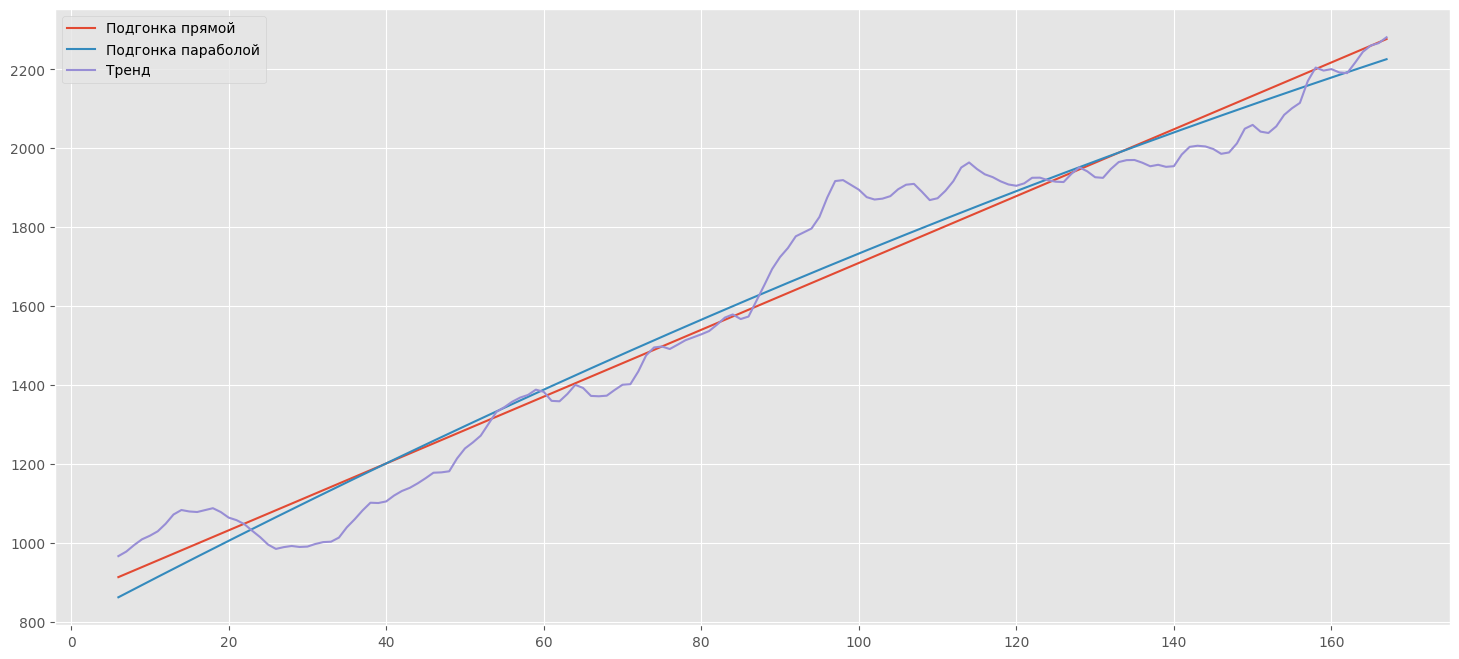

In [34]:
pred_trend = pd.DataFrame({
    'Подгонка прямой': y1,
    'Подгонка параболой': y2,
    'Тренд': y})
pred_trend.plot(figsize=(18,8));

In [35]:
X_forecast = pd.DataFrame({'month_num': range(175, 183)})
X_forecast['num^2'] = X_forecast['month_num']**2
X_forecast

,month_num,num^2
0,175,30625
1,176,30976
2,177,31329
3,178,31684
4,179,32041
5,180,32400
6,181,32761
7,182,33124


In [38]:
forecast_ = model2.predict(X_forecast)

Добавим в прогноз сезонные поправки

In [39]:
result.seasonal.head(12)

0     0.540901
1     0.712132
2     0.850900
3     0.928713
4     1.066588
5     1.089238
6     1.344878
7     1.342447
8     1.045089
9     0.948480
10    1.031874
11    1.098758
Name: seasonal, dtype: float64

In [40]:
forecast_2 = forecast_ * result.seasonal.iloc[0:8]

In [41]:
horizon_ = 8
valid = range(len(red)+1, len(red)+horizon_+1, 1) #номера месяцев, для которых делается прогноз
forecast_2.index = list(valid)

Text(0.5, 1.0, 'Прогноз продажи красного вина')

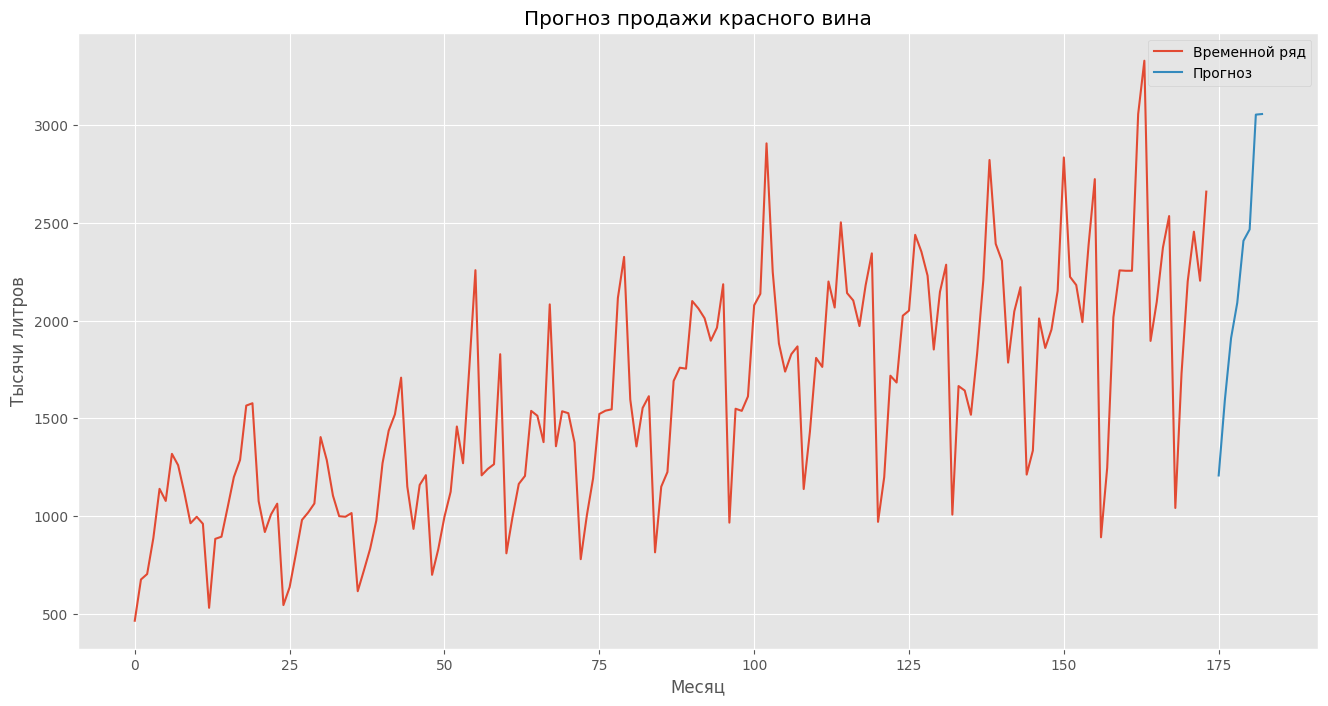

In [42]:
plt.figure(figsize=(16,8))
plt.plot(red, label='Временной ряд')
plt.plot(forecast_2, label='Прогноз')
plt.legend(loc='best')

plt.xlabel(u'Месяц')
plt.ylabel(u'Тысячи литров')
plt.title(u'Прогноз продажи красного вина')